In [1]:
from gpu_helper import enable_gpu

enable_gpu()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [2]:
%load_ext lab_black
%matplotlib inline
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

In [138]:
from toai.imports import *
from toai.data.utils import split_df
from toai.image import ImageResizer, ImageAugmentor
import tensorflow as tf
from tensorflow import keras
from matplotlib.patches import Rectangle
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from utils import *

In [5]:
DATA_DIR = Path("data/ArTaxOr")
DATA_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = Path("model")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

LOGS_DIR = Path("logs")
LOGS_DIR.mkdir(parents=True, exist_ok=True)

## Inspect data

In [6]:
!ls {DATA_DIR}

 ArTaxOr.png   Coleoptera   Hemiptera	  Lepidoptera   readme.txt
 Araneae       Diptera	    Hymenoptera   license.txt  'revision history.txt'


In [7]:
sample = (
    DATA_DIR
    / "Araneae"
    / "annotations"
    / os.listdir(DATA_DIR / "Araneae" / "annotations")[0]
)
with open(sample) as f:
    parsed = json.load(f)
    print(json.dumps(parsed, indent=4))

{
    "asset": {
        "format": "jpg",
        "id": "2ec404df21d8415f5be4c9cf7577bce7",
        "name": "7e26a39d8459.jpg",
        "path": "file:F:/ArTaxOr/Araneae/7e26a39d8459.jpg",
        "size": {
            "width": 1536,
            "height": 2048
        },
        "state": 2,
        "type": 1
    },
    "regions": [
        {
            "id": "lnJs7v5SP",
            "type": "RECTANGLE",
            "tags": [
                "Araneae"
            ],
            "boundingBox": {
                "height": 643.4329501915709,
                "width": 525.7318007662835,
                "left": 602.2375478927203,
                "top": 704.2452107279693
            },
            "points": [
                {
                    "x": 602.2375478927203,
                    "y": 704.2452107279693
                },
                {
                    "x": 1127.9693486590038,
                    "y": 704.2452107279693
                },
                {
                    "x

## Extract data

In [8]:
def extract_bounding_box(regions):
    points = regions[0]["points"]

    return [*points[0].values(), *points[2].values()]

In [9]:
def extract_file_info(asset_file, path):
    asset = asset_file["asset"]
    return [str(path / asset["name"])] + list(asset["size"].values())

In [10]:
def json_files_only(files):
    return [file for file in files if file.endswith(".json")]

In [11]:
def build_dataset(names):
    df = pd.DataFrame()

    for name in names:
        annotations_dir = DATA_DIR / name / "annotations"

        file_infos = []
        bboxs = []
        name_df = pd.DataFrame()
        for annotation in json_files_only(os.listdir(annotations_dir)):
            with open(annotations_dir / annotation) as json_file:
                parsed_json = json.load(json_file)
                regions = parsed_json["regions"]
                if len(regions) == 1:
                    file_infos.append(
                        [annotation, name]
                        + extract_file_info(parsed_json, DATA_DIR / name)
                    )
                    bboxs.append(extract_bounding_box(regions))

        name_df[["annotation", "tag", "file", "width", "height"]] = pd.DataFrame(
            file_infos
        )
        name_df[["x", "y", "x1", "y1"]] = pd.DataFrame(bboxs)

        df = df.append(name_df)

    return df

In [12]:
df = build_dataset(names=["Araneae", "Hemiptera", "Lepidoptera"])
df.shape

(5985, 9)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5985 entries, 0 to 1698
Data columns (total 9 columns):
annotation    5985 non-null object
tag           5985 non-null object
file          5985 non-null object
width         5985 non-null int64
height        5985 non-null int64
x             5985 non-null float64
y             5985 non-null float64
x1            5985 non-null float64
y1            5985 non-null float64
dtypes: float64(4), int64(2), object(3)
memory usage: 467.6+ KB


In [14]:
df.describe()

width       height            x            y           x1  \
count  5985.000000  5985.000000  5985.000000  5985.000000  5985.000000   
mean   2271.932331  1813.955388   636.656594   434.517911  1623.529231   
std    1157.745638   836.214019   526.796946   373.579378   749.136128   
min     500.000000   375.000000     0.000000     0.000000   309.212095   
25%    1536.000000  1353.000000   274.008276   170.666667  1147.126437   
50%    2048.000000  1536.000000   494.344828   331.034483  1442.409357   
75%    2048.000000  2048.000000   787.862069   572.484811  1824.367816   
max    5472.000000  5400.000000  3026.084080  2560.551724  4662.384562   

                y1  
count  5985.000000  
mean   1357.389359  
std     577.999639  
min     286.874706  
25%     973.900383  
50%    1230.847316  
75%    1626.445402  
max    4404.413793

In [15]:
df["x"] = df["x"] / df["width"]
df["x1"] = df["x1"] / df["width"]
df["y"] = df["y"] / df["height"]
df["y1"] = df["y1"] / df["height"]

df["object_width"] = df["x1"] - df["x"]
df["object_height"] = df["y1"] - df["y"]

In [16]:
df.head()

annotation      tag  \
0  2ec404df21d8415f5be4c9cf7577bce7-asset.json  Araneae   
1  cb3ee2eb83d63dc0fe14c50c7adc3e4c-asset.json  Araneae   
2  f3fe6bc9ee60243271c9b6ce83887c7a-asset.json  Araneae   
3  5338978297829b020dd2a70694677cd5-asset.json  Araneae   
4  8c18a24d0d64a2dfec29017b5961604f-asset.json  Araneae   

                                    file  width  height         x         y  \
0  data/ArTaxOr/Araneae/7e26a39d8459.jpg   1536    2048  0.392082  0.343870   
1  data/ArTaxOr/Araneae/81fc2d800057.jpg   2048    1536  0.416307  0.315134   
2  data/ArTaxOr/Araneae/410d4859f98f.jpg   4160    3120  0.398348  0.289272   
3  data/ArTaxOr/Araneae/3548ca9e1537.jpg   1627    2048  0.357302  0.340038   
4  data/ArTaxOr/Araneae/130e77c4c342.jpg   2048    1638  0.371396  0.239464   

         x1        y1  object_width  object_height  
0  0.734355  0.658046      0.342273       0.314176  
1  0.527658  0.624521      0.111351       0.309387  
2  0.633261  0.590038      0.234914       0.300766  
3  0.652839  0.664751      0.295537       0.324713  
4  0.777526  0.968391      0.406130       0.728927

## Preparing the dataset

In [17]:
BATCH_SIZE = 16
SHUFFLE_SIZE = 128
IMG_DIMS = (224, 224, 3)

In [18]:
cat_encoder = LabelEncoder()
cat_encoder.fit(df["tag"])
df["tag"] = cat_encoder.transform(df["tag"])

In [19]:
cat_encoder.classes_

array(['Araneae', 'Hemiptera', 'Lepidoptera'], dtype=object)

In [20]:
df.head()

annotation  tag  \
0  2ec404df21d8415f5be4c9cf7577bce7-asset.json    0   
1  cb3ee2eb83d63dc0fe14c50c7adc3e4c-asset.json    0   
2  f3fe6bc9ee60243271c9b6ce83887c7a-asset.json    0   
3  5338978297829b020dd2a70694677cd5-asset.json    0   
4  8c18a24d0d64a2dfec29017b5961604f-asset.json    0   

                                    file  width  height         x         y  \
0  data/ArTaxOr/Araneae/7e26a39d8459.jpg   1536    2048  0.392082  0.343870   
1  data/ArTaxOr/Araneae/81fc2d800057.jpg   2048    1536  0.416307  0.315134   
2  data/ArTaxOr/Araneae/410d4859f98f.jpg   4160    3120  0.398348  0.289272   
3  data/ArTaxOr/Araneae/3548ca9e1537.jpg   1627    2048  0.357302  0.340038   
4  data/ArTaxOr/Araneae/130e77c4c342.jpg   2048    1638  0.371396  0.239464   

         x1        y1  object_width  object_height  
0  0.734355  0.658046      0.342273       0.314176  
1  0.527658  0.624521      0.111351       0.309387  
2  0.633261  0.590038      0.234914       0.300766  
3  0.652839  0.664751      0.295537       0.324713  
4  0.777526  0.968391      0.406130       0.728927

In [21]:
train_df, val_df, test_df = split_df(df, 0.2, "tag")

In [22]:
class ImageParser:
    n_channels: int = 3

    def __call__(self, filename: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        image = tf.image.decode_jpeg(
            tf.io.read_file(filename), channels=self.n_channels
        )
        image = tf.image.convert_image_dtype(image, tf.float32)

        return image, label

__Note__ 

Use `num_parallel_calls=tf.data.experimental.AUTOTUNE` for _map()_ functions as it speeds up mapping process quite a lot.  
Without this param it takes:
- 3.51 s ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

With:
- 1.35 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [22]:
train_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            train_df["file"],
            tuple(
                [
                    train_df["tag"].values,
                    train_df[["x", "y", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(
        ImageResizer(IMG_DIMS, "stretch"),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .map(
        ImageAugmentor(level=3, rotate=False),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [23]:
validation_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            val_df["file"],
            tuple(
                [
                    val_df["tag"].values,
                    val_df[["x", "y", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(
        ImageResizer(IMG_DIMS, "stretch"),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

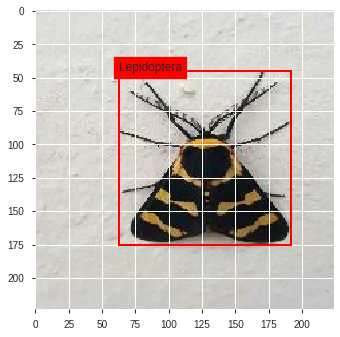

In [24]:
for x, y in train_set.take(1):
    categories, bounding_boxes = y
    category = categories[0].numpy()
    bounding_box = bounding_boxes[0].numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(x[0].numpy())
    plt.text(
        bounding_box[0] * IMG_DIMS[0],
        bounding_box[1] * IMG_DIMS[1],
        cat_encoder.inverse_transform([category])[0],
        backgroundcolor="red",
        fontsize=12,
    )
    y_rect = make_rectangle(*bounding_box, IMG_DIMS, "r")
    ax.add_patch(y_rect)
    plt.show()

## Creating the model

In [23]:
class GlobalConcatPooling2D(keras.layers.Layer):
    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        return keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(layer),
                keras.layers.GlobalMaxPool2D()(layer),
            ]
        )

In [24]:
n_categories = len(cat_encoder.classes_)

In [25]:
def make_model(base):
    x = keras.layers.GlobalMaxPool2D()(base.output)
    x = keras.layers.Dropout(0.3)(x)
    category = keras.layers.Dense(
        n_categories, activation=keras.activations.softmax, name="cat"
    )(x)
    bounding_box = keras.layers.Dense(
        4, activation=keras.activations.sigmoid, name="bbox"
    )(x)
    model = keras.Model(inputs=base.input, outputs=[category, bounding_box])
    model.compile(
        loss=[
            keras.losses.SparseCategoricalCrossentropy(),
            keras.losses.BinaryCrossentropy(),
        ],
        loss_weights=[0.5, 1.0],
        optimizer=keras.optimizers.Adam(3e-5),
    )
    return model

In [26]:
def callbacks(model_name):
    model_logs = LOGS_DIR / model_name
    model_logs.mkdir(parents=True, exist_ok=True)

    return [
        keras.callbacks.ModelCheckpoint(
            str(MODEL_DIR / f"{model_name}.h5"),
            save_best_only=True,
            save_weights_only=True,
        ),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=2),
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.TensorBoard(log_dir=str(model_logs), histogram_freq=1),
    ]

In [81]:
model_xc = make_model(
    keras.applications.Xception(
        input_shape=IMG_DIMS, include_top=False, weights="imagenet"
    )
)

In [30]:
history = model_xc.fit(
    x=train_set,
    validation_data=validation_set,
    steps_per_epoch=math.ceil(train_df.shape[0] / BATCH_SIZE),
    epochs=20,
    callbacks=callbacks("Xception_base"),
)

Train for 300 steps, validate for 38 steps
Epoch 1/20
300/300 [==============================] - 95s 317ms/step - loss: 1.0211 - cat_loss: 0.7441 - bbox_loss: 0.6491 - val_loss: 0.8183 - val_cat_loss: 0.4070 - val_bbox_loss: 0.6148
Epoch 2/20
300/300 [==============================] - 80s 266ms/step - loss: 0.8188 - cat_loss: 0.4175 - bbox_loss: 0.6100 - val_loss: 0.7583 - val_cat_loss: 0.3287 - val_bbox_loss: 0.5939
Epoch 3/20
300/300 [==============================] - 80s 268ms/step - loss: 0.7473 - cat_loss: 0.2924 - bbox_loss: 0.6011 - val_loss: 0.7544 - val_cat_loss: 0.3313 - val_bbox_loss: 0.5887
Epoch 4/20
300/300 [==============================] - 85s 284ms/step - loss: 0.6916 - cat_loss: 0.1934 - bbox_loss: 0.5949 - val_loss: 0.7440 - val_cat_loss: 0.3169 - val_bbox_loss: 0.5856
Epoch 5/20
300/300 [==============================] - 78s 259ms/step - loss: 0.6570 - cat_loss: 0.1324 - bbox_loss: 0.5908 - val_loss: 0.7307 - val_cat_loss: 0.2969 - val_bbox_loss: 0.5822
Epoch 6/20
3

In [33]:
make_report(model_xc, validation_set)

              precision    recall  f1-score   support

     Araneae       0.90      0.93      0.92       212
   Hemiptera       0.95      0.86      0.90       216
 Lepidoptera       0.88      0.95      0.91       170

    accuracy                           0.91       598
   macro avg       0.91      0.91      0.91       598
weighted avg       0.91      0.91      0.91       598



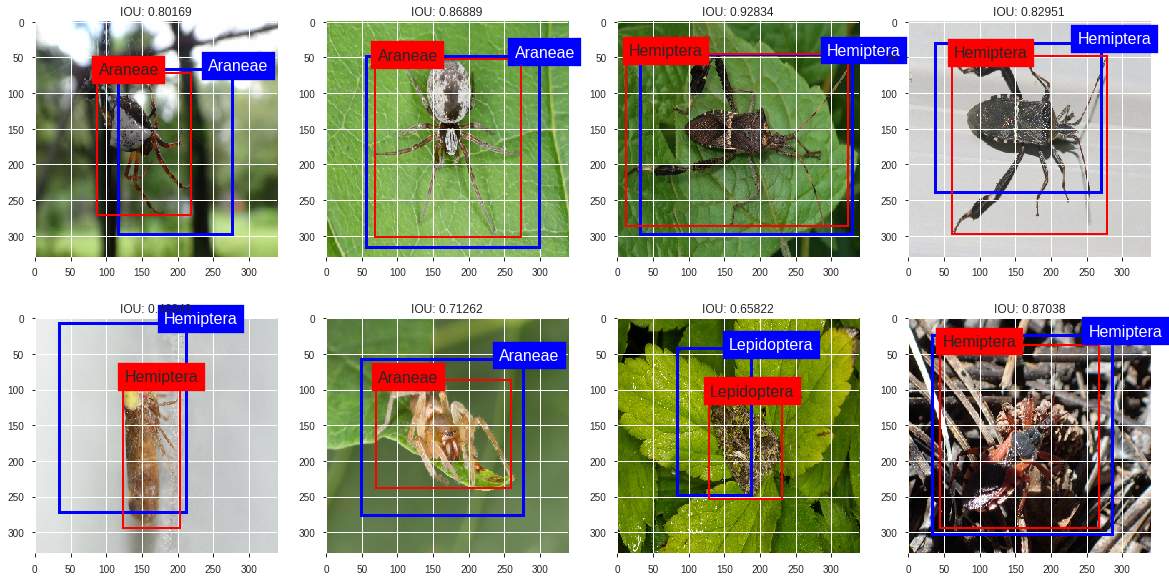

In [143]:
show_predictions_iou(model_xc, validation_set, IMG_DIMS, cat_encoder)

In [85]:
model_VGG16 = make_model(
    base=keras.applications.VGG16(
        input_shape=IMG_DIMS, include_top=False, weights="imagenet"
    )
)

In [35]:
history_vgg16 = model_VGG16.fit(
    x=train_set,
    validation_data=validation_set,
    steps_per_epoch=math.ceil(train_df.shape[0] / BATCH_SIZE),
    epochs=20,
    callbacks=callbacks("vgg16_base"),
)

Train for 300 steps, validate for 38 steps
Epoch 1/20
300/300 [==============================] - 87s 289ms/step - loss: 1.1565 - cat_loss: 1.0290 - bbox_loss: 0.6420 - val_loss: 0.9250 - val_cat_loss: 0.6419 - val_bbox_loss: 0.6041
Epoch 2/20
300/300 [==============================] - 82s 274ms/step - loss: 0.9247 - cat_loss: 0.6228 - bbox_loss: 0.6133 - val_loss: 0.8689 - val_cat_loss: 0.5389 - val_bbox_loss: 0.5994
Epoch 3/20
300/300 [==============================] - 85s 282ms/step - loss: 0.8192 - cat_loss: 0.4249 - bbox_loss: 0.6068 - val_loss: 0.8242 - val_cat_loss: 0.4698 - val_bbox_loss: 0.5893
Epoch 4/20
300/300 [==============================] - 81s 269ms/step - loss: 0.7488 - cat_loss: 0.2954 - bbox_loss: 0.6011 - val_loss: 0.7715 - val_cat_loss: 0.3680 - val_bbox_loss: 0.5875
Epoch 5/20
300/300 [==============================] - 77s 256ms/step - loss: 0.6919 - cat_loss: 0.1843 - bbox_loss: 0.5997 - val_loss: 0.7897 - val_cat_loss: 0.4104 - val_bbox_loss: 0.5845
Epoch 6/20
3

In [36]:
make_report(model_VGG16, validation_set)

              precision    recall  f1-score   support

     Araneae       0.92      0.87      0.90       212
   Hemiptera       0.88      0.87      0.87       216
 Lepidoptera       0.85      0.92      0.88       170

    accuracy                           0.88       598
   macro avg       0.88      0.89      0.88       598
weighted avg       0.88      0.88      0.88       598



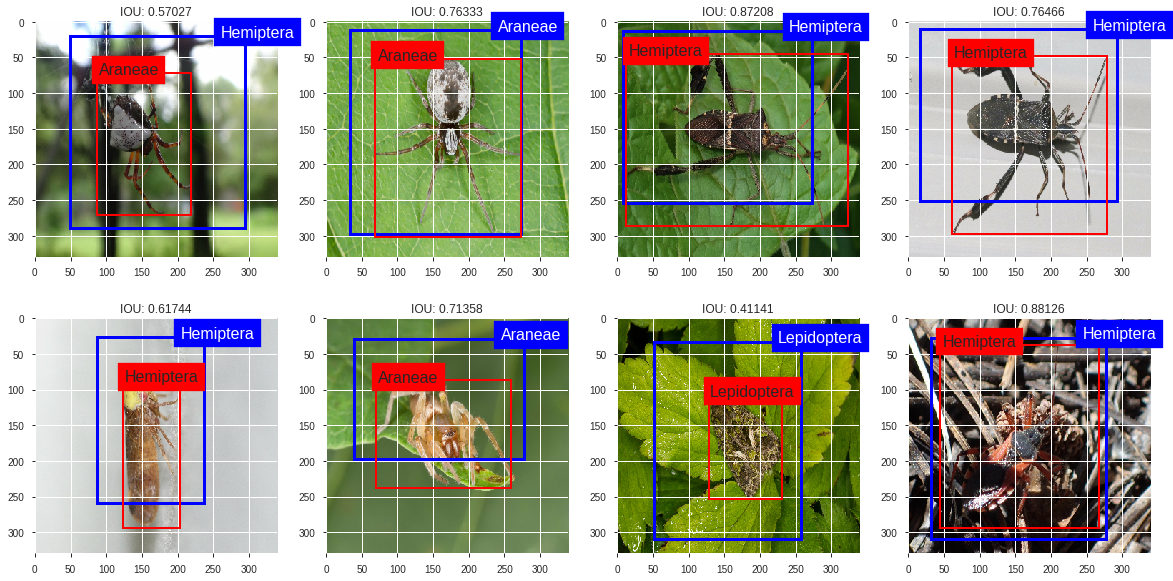

In [144]:
show_predictions_iou(model_VGG16, validation_set, IMG_DIMS, cat_encoder)

In [88]:
model_resnet50 = make_model(
    base=keras.applications.ResNet50V2(
        input_shape=IMG_DIMS, include_top=False, weights="imagenet"
    )
)

In [38]:
history_resnet50 = model_resnet50.fit(
    x=train_set,
    validation_data=validation_set,
    steps_per_epoch=math.ceil(train_df.shape[0] / BATCH_SIZE),
    epochs=20,
    callbacks=callbacks("resnet_base"),
)

Train for 300 steps, validate for 38 steps
Epoch 1/20
300/300 [==============================] - 90s 300ms/step - loss: 3.1282 - cat_loss: 2.7484 - bbox_loss: 1.7541 - val_loss: 1.2782 - val_cat_loss: 0.8327 - val_bbox_loss: 0.8619
Epoch 2/20
300/300 [==============================] - 82s 274ms/step - loss: 1.1420 - cat_loss: 0.8118 - bbox_loss: 0.7361 - val_loss: 0.9541 - val_cat_loss: 0.5775 - val_bbox_loss: 0.6653
Epoch 3/20
300/300 [==============================] - 82s 273ms/step - loss: 0.9785 - cat_loss: 0.5985 - bbox_loss: 0.6792 - val_loss: 0.9089 - val_cat_loss: 0.5386 - val_bbox_loss: 0.6397
Epoch 4/20
300/300 [==============================] - 85s 282ms/step - loss: 0.9075 - cat_loss: 0.4993 - bbox_loss: 0.6578 - val_loss: 0.8581 - val_cat_loss: 0.4695 - val_bbox_loss: 0.6234
Epoch 5/20
300/300 [==============================] - 81s 268ms/step - loss: 0.8398 - cat_loss: 0.3865 - bbox_loss: 0.6465 - val_loss: 0.8347 - val_cat_loss: 0.4349 - val_bbox_loss: 0.6173
Epoch 6/20
3

In [40]:
make_report(model_resnet50, validation_set)

              precision    recall  f1-score   support

     Araneae       0.91      0.86      0.88       212
   Hemiptera       0.90      0.85      0.87       216
 Lepidoptera       0.82      0.94      0.88       170

    accuracy                           0.88       598
   macro avg       0.88      0.88      0.88       598
weighted avg       0.88      0.88      0.88       598



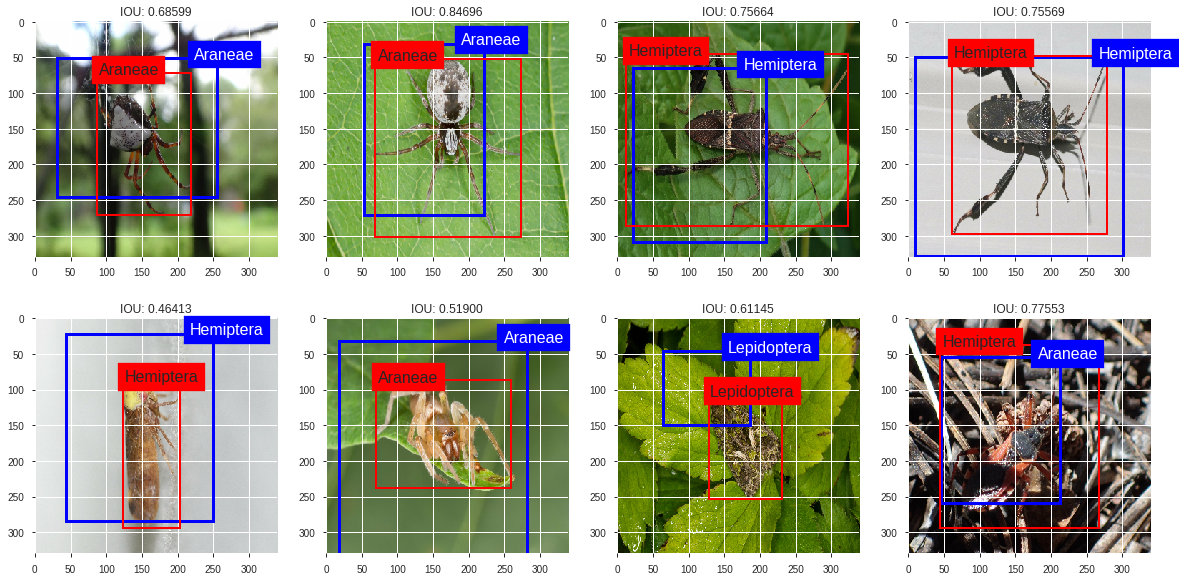

In [145]:
show_predictions_iou(model_resnet50, validation_set, IMG_DIMS, cat_encoder)

### Final model Xception with increased image sizes

In [149]:
IMG_DIMS = (330, 340, 3)
BATCH_SIZE = 8  # reducing batch size since my GPU can't handle much more

In [28]:
train_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            train_df["file"],
            tuple(
                [
                    train_df["tag"].values,
                    train_df[["x", "y", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(
        ImageResizer(IMG_DIMS, "stretch"),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .map(
        ImageAugmentor(level=3, rotate=False),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [29]:
validation_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            val_df["file"],
            tuple(
                [
                    val_df["tag"].values,
                    val_df[["x", "y", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(
        ImageResizer(IMG_DIMS, "stretch"),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [30]:
model = make_model(
    keras.applications.Xception(
        input_shape=IMG_DIMS, include_top=False, weights="imagenet"
    )
)

In [32]:
history = model.fit(
    x=train_set,
    validation_data=validation_set,
    steps_per_epoch=math.ceil(train_df.shape[0] / BATCH_SIZE),
    epochs=20,
    callbacks=callbacks("Xception_base_2"),
)

Train for 599 steps, validate for 75 steps
Epoch 1/20
599/599 [==============================] - 164s 274ms/step - loss: 0.6912 - cat_loss: 0.1819 - bbox_loss: 0.6003 - val_loss: 0.6718 - val_cat_loss: 0.1826 - val_bbox_loss: 0.5805
Epoch 2/20
599/599 [==============================] - 157s 263ms/step - loss: 0.6291 - cat_loss: 0.0950 - bbox_loss: 0.5816 - val_loss: 0.6753 - val_cat_loss: 0.1986 - val_bbox_loss: 0.5760
Epoch 3/20
599/599 [==============================] - 157s 262ms/step - loss: 0.6066 - cat_loss: 0.0571 - bbox_loss: 0.5781 - val_loss: 0.6904 - val_cat_loss: 0.2309 - val_bbox_loss: 0.5749
Epoch 4/20
599/599 [==============================] - 158s 263ms/step - loss: 0.5917 - cat_loss: 0.0341 - bbox_loss: 0.5746 - val_loss: 0.6714 - val_cat_loss: 0.1946 - val_bbox_loss: 0.5741
Epoch 5/20
599/599 [==============================] - 157s 262ms/step - loss: 0.5870 - cat_loss: 0.0255 - bbox_loss: 0.5743 - val_loss: 0.6740 - val_cat_loss: 0.2016 - val_bbox_loss: 0.5732
Epoch 6

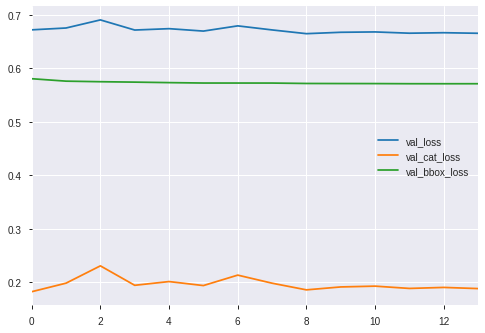

In [36]:
show_history(history, contains="val")

In [148]:
make_report(model_xc, validation_set, cat_encoder)

              precision    recall  f1-score   support

     Araneae       0.95      0.95      0.95       212
   Hemiptera       0.89      0.96      0.92       216
 Lepidoptera       0.98      0.86      0.92       170

    accuracy                           0.93       598
   macro avg       0.94      0.93      0.93       598
weighted avg       0.93      0.93      0.93       598



In [39]:
make_report(model, validation_set, cat_encoder)

              precision    recall  f1-score   support

     Araneae       0.94      0.95      0.94       212
   Hemiptera       0.95      0.91      0.93       216
 Lepidoptera       0.92      0.95      0.93       170

    accuracy                           0.94       598
   macro avg       0.94      0.94      0.94       598
weighted avg       0.94      0.94      0.94       598



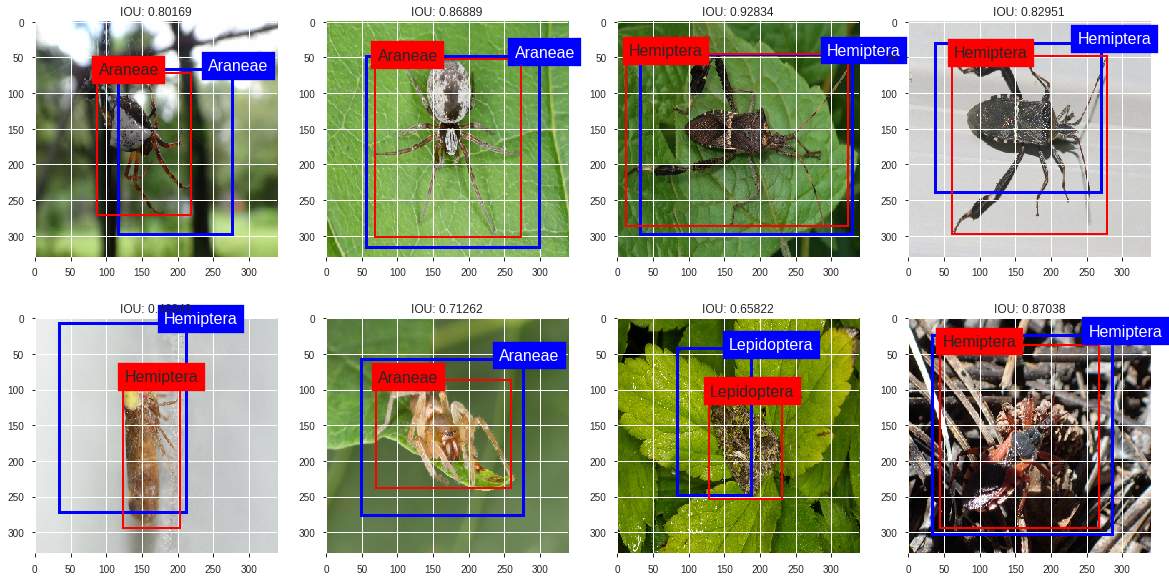

In [146]:
show_predictions_iou(model_xc, validation_set, IMG_DIMS, cat_encoder)

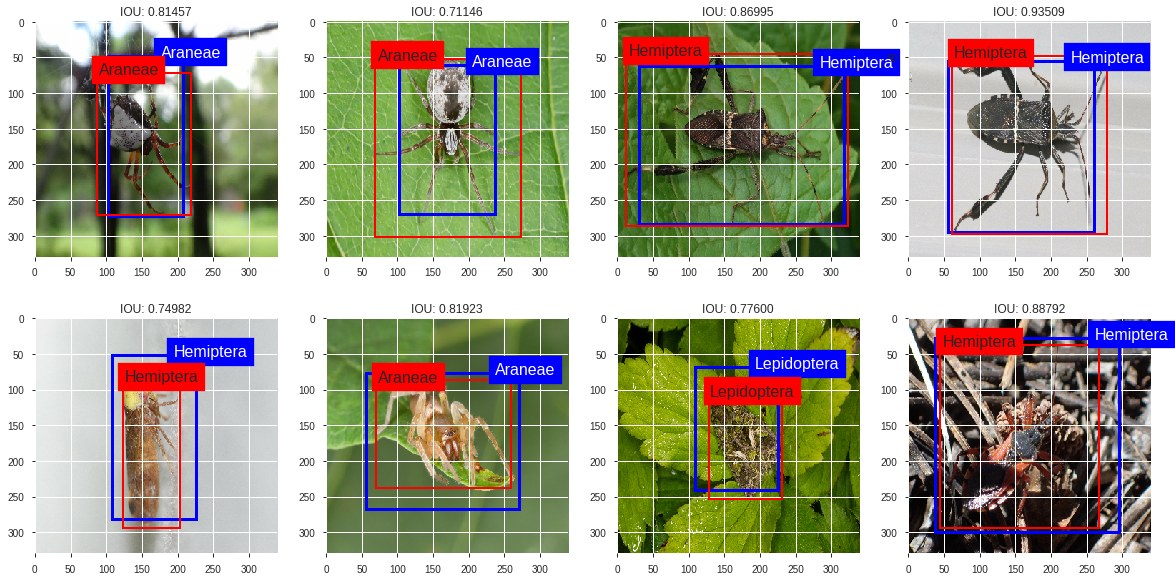

In [142]:
show_predictions_iou(model, validation_set, IMG_DIMS, cat_encoder)

Fin.